# TODO

1. Pick a Dataset
2. Download the dataset
3. Import the dataset using Pytorch
4. Explore the dataset
5. Prepare the dataset for training

In [2]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification'
od.download(dataset_url)

  1%|▏         | 5.00M/346M [00:00<00:07, 47.7MB/s]

100%|██████████| 346M/346M [00:01<00:00, 251MB/s]


# Import Dataset into Pytorch

Use the ImageFolder class from torchvision

In [5]:
import os
train_dir = './intel-image-classification/seg_test/seg_test'
test_dir = './intel-image-classification/seg_train/seg_train'

In [6]:
os.listdir(train_dir)

['mountain', 'glacier', 'sea', 'forest', 'buildings', 'street']

In [7]:
for cls in os.listdir(train_dir):
    print(cls, ':', len(os.listdir(train_dir +'/'+ cls)))

mountain : 525
glacier : 553
sea : 510
forest : 474
buildings : 437
street : 501


In [8]:
from torchvision.datasets import ImageFolder

In [9]:
dataset = ImageFolder(train_dir)

In [10]:
len(dataset)

3000

In [11]:
dataset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

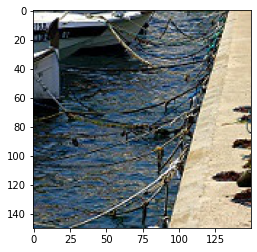

In [13]:
img, label = dataset[2001]
plt.imshow(img)

In [14]:
import torchvision.transforms as tt
dataset = ImageFolder(train_dir,tt.Compose([tt.Resize(128),
                                            tt.RandomCrop(128),
                                            tt.ToTensor()]))

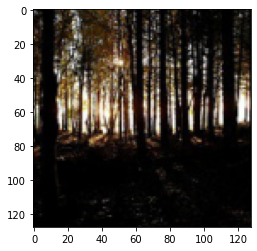

In [15]:
img, label = dataset[644]
plt.imshow(img.permute((1,2,0)))

In [16]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_size = len(dataset) - val_size
train_size, val_size

(2700, 300)

In [17]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset,[train_size,val_size])
len(train_ds), len(val_ds)

(2700, 300)

In [18]:
from torch.utils.data import DataLoader
batch_size = 64

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      pin_memory = True,
                      num_workers = 5)
val_dl = DataLoader(train_ds,
                      batch_size,
                      pin_memory = True,
                      num_workers = 5,
                      )

In [19]:
from torchvision.utils import make_grid

def show_batch(dl):
    for imgs, labels in dl:
        fig, ax = plt.subplots(figsize = (30,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(imgs, nrow=16).permute(1,2,0))
        break

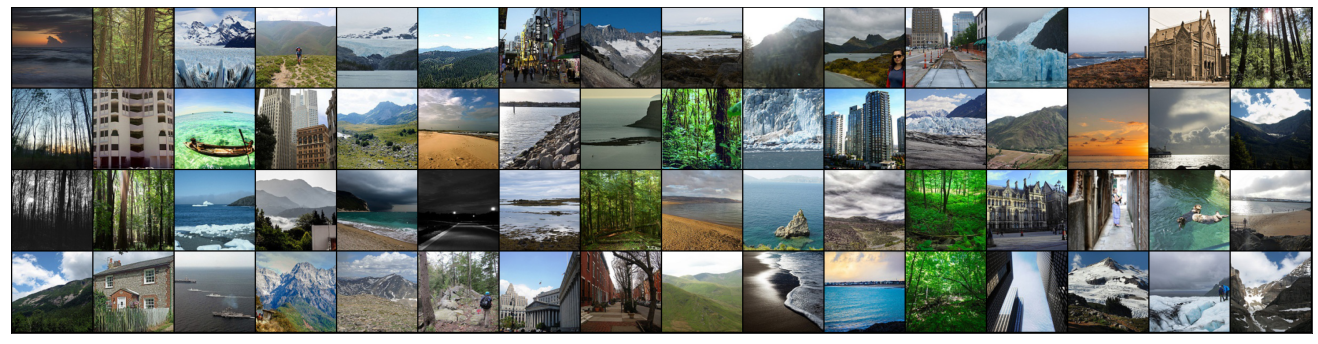

In [20]:
show_batch(train_dl)

## Utility functions and classes

In [21]:
import torch

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for bt in self.dl:
            yield to_device(bt,self.device)

    def __len__(self):
        return len(self.dl)


In [22]:
torch.cuda.is_available()

True

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

# Model and Training Utilities 

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        # calculate loss for a batch of training data
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss

    def validation_step(self,batch):
        # calculate loss & accuracy for a batch of validation data
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss': loss.detach(), 'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_losses = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_accs = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_losses.item(), 'val_acc': epoch_accs.item()}

    def epoch_end(self,epoch,result):
        print('Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch,result['train_loss'],result['val_loss'],result['val_acc']))
    
def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [26]:
#Practice diff loss functions
# import torch.nn.functional as F
# input = torch.randn((3, 3), requires_grad=True)
# target = torch.rand((3, 3), requires_grad=False)
# loss = F.binary_cross_entropy(torch.sigmoid(input), target)
# input,target

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    # Evalutes the models performance on the validation set
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model

Resnet 9 architecture

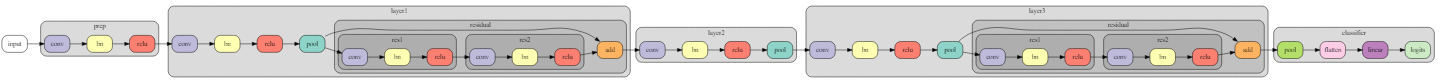

In [28]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 128 x 128
        self.conv1 = conv_block(in_channels, 64)  # Input: 128 x 64 x 128 x 128
        self.conv2 = conv_block(64, 128, pool=True) # Input: 128 x 128 x 64 x 64
        self.res1 = nn.Sequential(conv_block(128, 128), # Input: 128 x 128 x 64 x 64
                                  conv_block(128, 128)) # Input: 128 x 128 x 64 x 64
        
        self.conv3 = conv_block(128, 256, pool=True) # Input: 128 x 256 x 32 x 32
        self.conv4 = conv_block(256, 512, pool=True)  # Input: 128 x 512 x 16 x 16
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # Input: 128 x 512 x 4 x 4
                                        nn.Flatten(), # Input: 128 x  512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [29]:
model = to_device(ResNet9(3,len(dataset.classes)),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [30]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model.

In [31]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('',images.shape)
    print(images.device)
    preds = model(images)
    print('Preds shape',preds.shape)
    break

 torch.Size([64, 3, 128, 128])
cuda:0
Preds shape torch.Size([64, 6])


### Training

In [32]:
history = [evaluate(model,val_dl)]
history

[{'val_acc': 0.1431685984134674, 'val_loss': 1.794326901435852}]

In [34]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.5777, val_loss: 1.3082, val_acc: 0.4965
Epoch [1], train_loss: 1.3229, val_loss: 1.1523, val_acc: 0.5606
Epoch [2], train_loss: 1.1916, val_loss: 1.0431, val_acc: 0.5766
Epoch [3], train_loss: 1.0686, val_loss: 0.9517, val_acc: 0.6355
Epoch [4], train_loss: 1.0135, val_loss: 0.8475, val_acc: 0.6813


In [35]:
jovian.commit(pro'Deep learning from scratch')

[jovian] Detected Colab notebook...


[jovian] Error: Please provide the project argument for the first commit e.g. jovian.commit(project='my-project')
